In [1]:
import pandas as pd
import numpy as np
import keras
import umap
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
gpus= tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)



In [2]:

class SampledData():
    def __init__(self, fname, sort=True, cut=True, sortcol='total', datasize=20000, samplenum = 500):
        self.df = pd.read_csv(fname)

        if(sort == True):
            self.df = self.df.sort_values(by=[sortcol], ascending=False).reset_index(drop=True)
        if(cut == True):
            self.df = self.df.iloc[:datasize]

        self.df = self.df[["utr", "rl"]]

        self.sampled_df = pd.DataFrame()
        for interval in [3,5,7]:
            df_tmp = self.df.loc[(self.df['rl'] < interval + 0.5) & (self.df['rl'] > interval - 0.5)]
            df_tmp = df_tmp.sample(n=samplenum,random_state=1).reset_index(drop=True)
            df_tmp["class"] = interval
            # print(df_tmp)
            self.sampled_df = pd.concat([self.sampled_df, df_tmp])
        self.sampled_df.reset_index(inplace=True, drop=True)

    def get_df(self):
        return self.df

    def get_seqs(self):
        return self.df['utr']

    def get_data_size(self):
        return len(self.df)

    def get_sampled_df(self):
        return self.sampled_df

def onehot_coder(data, seqs):  ## one hot coding for input seq
    inp_len = 50
    nuc_d = {'a': [1, 0, 0, 0], 'c': [0, 1, 0, 0], 'g': [0, 0, 1, 0], 't': [0, 0, 0, 1]}

    onehotmtx = np.empty([len(data),inp_len,4])
    for i in range(len(data)):
        seq = seqs.iloc[i]
        seq = seq.lower()[:50]
        for n, x in enumerate(seq):
            onehotmtx[i][n] = np.array(nuc_d[x])

    return onehotmtx


def get_bottleneck(df, encoder):

    high_neck = encoder.predict(onehot_coder(df, df["utr"]))
    return high_neck


In [3]:
## load customized loss

## load customized loss

def weighted_squared_error(y_true, y_pred):

    ltavg = y_true > 0

    mse = K.square(y_pred - y_true)
    weighted_mse = (1 + y_true) * K.square(y_pred - y_true)

    return K.mean(tf.where(ltavg, weighted_mse, mse))


losses = {
    "rl_output": weighted_squared_error,
    "decoded_output": 'categorical_crossentropy',
}

In [4]:
## load data (a held out test detaset)
testdata = SampledData("../data/GSM3130440_egfp_m1pseudo_2.csv", sort=True, cut=True,
                       sortcol='total', datasize=20000, samplenum = 1000)

## load model:

autoencoder = keras.models.load_model('../models/Smart5UTR/Smart5UTR_egfp_m1pseudo2_Model.h5',compile=False)


autoencoder.compile(loss=losses,
                    metrics={'rl_output': 'mse', 'decoded_output': 'accuracy'})


## extract encoder
for layer in autoencoder.layers[:]:  ## frozen
    layer.trainable = False
encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('concatenate').output)

## transform input sequence to autoencoder's latent vector
ebddata = testdata.get_sampled_df()

In [5]:
ebddata

,utr,rl,class
0,CCGTATAAGTTTGGTAGAACAAGCGATGGACATACAACTGGAAAAC...,2.838999,3
1,CAAAGGCGATCGGGCCCAGTTTATCATGACCAACTACGGTGACAAA...,3.456780,3
2,CCTGGCGGAAGAGACATGCGATATGCAATCGGTACTTGAAAAGCCT...,3.170844,3
3,GCGCGCGACAGAACCGTATCGTCATATAATGGCTGCGAACGAATAG...,3.310671,3
4,AATGGGAATCGACGGCGTCCAGGGATGAAGCATACCCTTCCAGGCC...,3.249569,3
...,...,...,...
2995,TTCAGGAATCCTGCTATACGGACTGATACCGGACCATACACTCGCT...,6.788409,7
2996,GAAAATTCCCGAATCCCGGTCGACCCTGGAAGTGCATGACAGAGTC...,6.573670,7
2997,CGATGGCTTCCTCTACTAAGGTTCAAACAGTGGAAAATAGCGGCAG...,6.741382,7
2998,TAACGGCGGAACCCGACCAAGATCTCGCACTGGGCGGACCCAATCG...,6.537757,7


In [6]:
embedding = get_bottleneck(ebddata,encoder)  ## two-dim embedding matrix



In [7]:
## perform umap

umap_embedding = umap.UMAP(n_components=2, n_neighbors=10,random_state=1234).fit_transform(embedding)

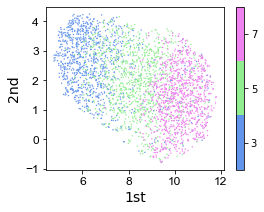

In [8]:

## draw ebd plot:

## set color for classes

classes = [3,5,7]
class_num = 3
labels = ebddata['class']
labels_c = [classes.index(l) for l in labels]
# cmp = matplotlib.colors.ListedColormap(['green','dodgerblue','deeppink'])  ##  "low", "medium", "high"
cmp = matplotlib.colors.ListedColormap(["cornflowerblue", "lightgreen", "violet"])



f3 = plt.figure()
f3.set_size_inches((4, 3))
# plt.title("UMAP Visualiztion: sampled 5' UTR embedding")
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=labels_c, s=2, edgecolor='none', cmap=cmp) #, norm=mpl.colors())
plt.xlabel('1st', size=14)
plt.ylabel('2nd', size=14)
plt.xticks(fontproperties = 'Arial', size = 12)
plt.yticks(fontproperties = 'Arial', size = 12)


cbar = plt.colorbar(boundaries=np.arange(class_num+1)-0.5)
cbar.set_ticks(np.arange(class_num))
cbar.set_ticklabels(classes)

In [9]:
f3.savefig('../figs/fig3-vis-embedding.png', dpi=200)